# Effect of weather on AFL Games

## Introduction

The objective of this project is to determine whether or not variables such as rainfall effect scoring in games of AFL played at the M.C.G, with games from 2015 to 2019.

Table of contents:

Overview section
* Data Preparation
* Some other section
* Another section

## Data Preparation

### Preliminaries

In [82]:
# Module Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [128]:
# Read & Clean Game Data

gameData = pd.read_csv('data/all_games_2015_2019.csv', sep = ',')
gameData = gameData.drop(columns = ['id', 'Round'])
gameData['Date'] = gameData['Date'].str.split(' ').str[0]

indexNames = gameData[gameData['Venue'] != 'M.C.G.'].index
gameData.drop(indexNames, inplace=True)

gameData['Total.Score'] = gameData['Home.Points'] + gameData['Away.Points']
gameData['Total.Goals'] = gameData['Home.Goals'] + gameData['Away.Goals']
gameData['Total.Behinds'] = gameData['Home.Behinds'] + gameData['Away.Behinds']

# Read & Clean Weather Data

years = ['2015', '2016', '2017', '2018', '2019']
weatherData = pd.read_csv('data/IDCJAC0009_086338_1800_Data.csv', sep = ',')
weatherData = weatherData.loc[weatherData['Year'].isin(years)]
weatherData['Month'] = weatherData['Month'].map(lambda x: str(x).zfill(2))
weatherData['Day'] = weatherData['Day'].map(lambda x: str(x).zfill(2))
weatherData['Date'] = weatherData['Year'].astype(str) + '-' + weatherData['Month'] + '-' + weatherData['Day'].astype(str)
weatherData = weatherData.drop(columns = ['Year', 'Month', 'Day', 'Product code', 'Bureau of Meteorology station number', 'Period over which rainfall was measured (days)', 'Quality'])

# Read & Clean Solar Data

solarData = pd.read_csv('data/IDCJAC0016_086338_1800_Data.csv', sep = ',')
solarData = solarData.loc[solarData['Year'].isin(years)]
solarData['Month'] = solarData['Month'].map(lambda x: str(x).zfill(2))
solarData['Day'] = solarData['Day'].map(lambda x: str(x).zfill(2))
solarData['Date'] = solarData['Year'].astype(str) + '-' + solarData['Month'] + '-' + solarData['Day'].astype(str)
solarData = solarData.drop(columns = ['Year', 'Month', 'Day', 'Product code', 'Bureau of Meteorology station number'])

# Combined Data Sets

data = gameData.merge(weatherData, on = 'Date').merge(solarData, on = 'Date')
data = data.rename(columns = {'Daily global solar exposure (MJ/m*m)': 'solar_exposure', 'Rainfall amount (millimetres)': 'daily_rainfall'})

In [129]:
data

,Date,Venue,Round.Number,Home.Team,Home.Goals,Home.Behinds,Home.Points,Away.Team,Away.Goals,Away.Behinds,Away.Points,Margin,Total.Score,Total.Goals,Total.Behinds,daily_rainfall,solar_exposure
0,2015-04-02,M.C.G.,1,Carlton,11,12,78,Richmond,15,15,105,-27,183,26,27,0.2,17.5
1,2015-04-04,M.C.G.,1,Melbourne,17,13,115,Gold Coast,13,11,89,26,204,30,24,0.0,16.2
2,2015-04-06,M.C.G.,1,Hawthorn,17,21,123,Geelong,8,13,61,62,184,25,34,0.0,13.0
3,2015-04-11,M.C.G.,2,Richmond,9,12,66,Footscray,12,13,85,-19,151,21,25,0.0,14.9
4,2015-04-12,M.C.G.,2,Essendon,12,6,78,Hawthorn,11,10,76,2,154,23,16,0.0,13.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2019-09-06,M.C.G.,24,Collingwood,9,7,61,Geelong,7,9,51,10,112,16,16,2.0,10.4
246,2019-09-13,M.C.G.,25,Geelong,13,10,88,West Coast,10,8,68,20,156,23,18,0.0,14.0
247,2019-09-20,M.C.G.,26,Richmond,12,13,85,Geelong,9,12,66,19,151,21,25,0.0,14.4
248,2019-09-21,M.C.G.,26,GWS,8,8,56,Collingwood,7,10,52,4,108,15,18,0.0,10.5


In [111]:
weatherData

,Rainfall amount (millimetres),Date
730,0.0,2015-01-01
731,0.0,2015-01-02
732,0.0,2015-01-03
733,4.2,2015-01-04
734,0.0,2015-01-05
...,...,...
2551,0.0,2019-12-27
2552,0.0,2019-12-28
2553,0.0,2019-12-29
2554,0.0,2019-12-30


## Data Plots

### Basic Scatter Plots

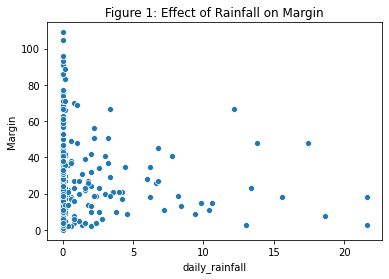

In [130]:
# create scatterplot 
sns.scatterplot(data['daily_rainfall'], data['Margin'].abs())
plt.title('Figure 1: Effect of Rainfall on Margin')
plt.show();



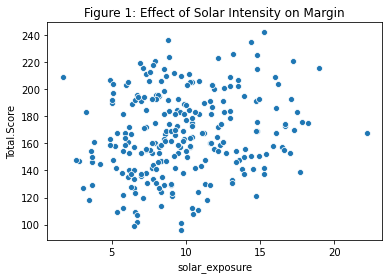

In [140]:
# create scatterplot 
sns.scatterplot(data['solar_exposure'], data['Total.Score'])
plt.title('Figure 1: Effect of Solar Intensity on Margin')
plt.show();


In [144]:
# test plot